In [1]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

# Forecasting

In [3]:
df = pd.read_csv('/Users/sunwoonam/Desktop/Griffith/2023_T1/7130ICT_Data Analytics/Lab/Lab4/forecasting_data.csv')
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


## 1. Visualize and interprete the pattern of this time-series

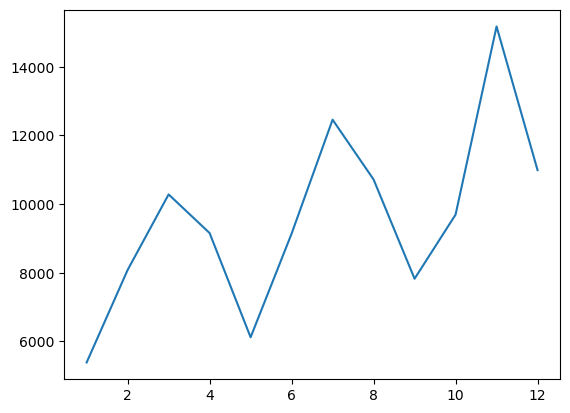

In [5]:
data = pd.read_csv('/Users/sunwoonam/Desktop/Griffith/2023_T1/7130ICT_Data Analytics/Lab/Lab4/forecasting_data.csv')

plt.plot(data['Period'], data['Sales'])
plt.show()

## 2. Predict future demand in the four next quarters without seasonality

### Using moving average

/var/folders/75/x_d6mzk10nl3lsdps6lhcc880000gn/T/ipykernel_97941/1805827529.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_average_df = moving_average_df.append({'Period': i, 'Sales': period_sales}, ignore_index=True)
/var/folders/75/x_d6mzk10nl3lsdps6lhcc880000gn/T/ipykernel_97941/1805827529.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_average_df = moving_average_df.append({'Period': i, 'Sales': period_sales}, ignore_index=True)
/var/folders/75/x_d6mzk10nl3lsdps6lhcc880000gn/T/ipykernel_97941/1805827529.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_average_df = moving_average_df.append({'Period': i, 'Sales': period_sales}, ignore_index=True)
/var/folders/75/x_d6mzk10nl3lsdps6lhcc88000

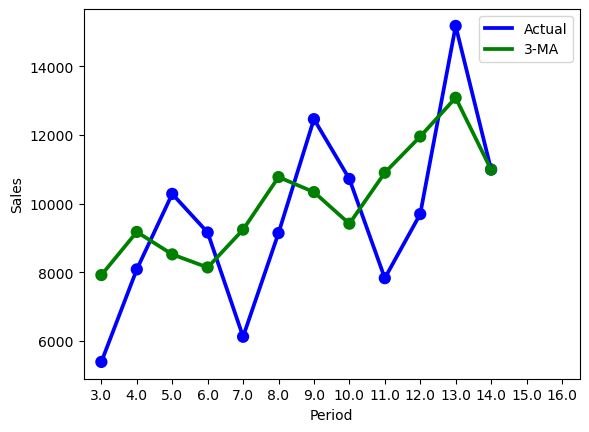

In [6]:
# Using moving average
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period', 'Sales'])

    for i in range(k, to_period+1):
        period_sales = df['Sales'][i-k:i].mean()
        moving_average_df = moving_average_df.append({'Period': i, 'Sales': period_sales}, ignore_index=True)

    return moving_average_df


f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()

### Using exponential smoothing

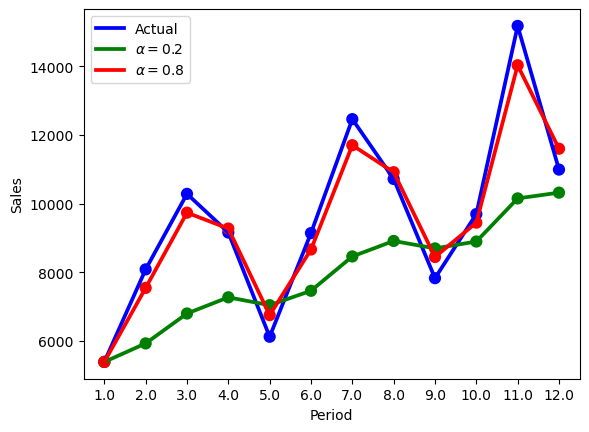

In [8]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period', 'Sales'])
    es_df.loc[0] = [df['Period'][0], df['Sales'][0]]

    for i in range(1, len(df)):
        period_sales = alpha * df['Sales'][i] + (1 - alpha) * es_df['Sales'][i-1]
        es_df.loc[i] = [df['Period'][i], period_sales]

    return es_df


f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

## 3. Predict future demand in the four next quarters with seasonality

In [16]:
#season function

def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
    
def get_seq(row):
    return (row['Period'] - 1) % 4

def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)

    season_df = pd.DataFrame((new_df.pivot('Seq', 'Season')['Sales']).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis=1)

    avg_df = season_df.mean()

    seasonal_index_df = pd.DataFrame(columns=['I', 'II', 'III'])
    seasonal_index_df['I'] = season_df['I'] / avg_df['I']
    seasonal_index_df['II'] = season_df['II'] / avg_df['II']
    seasonal_index_df['III'] = season_df['III'] / avg_df['III']
    seasonal_index_df['Avg'] = seasonal_index_df.mean(axis=1)

    season = np.array([1, 2, 3])
    avg_arr = np.array([avg_df['I'], avg_df['II'], avg_df['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)

    forecast_avg = avg_df['Avg'].values[-1] * average_predict
    forecast_seasonality = seasonal_index_df.loc[3, 'I':'III'].values
    forecast_sales = forecast_avg * forecast_seasonality

    forecast_df = pd.DataFrame({'Period': months, 'Sales': forecast_sales})
    forecast_df['Period'] = forecast_df['Period'].astype(int)
    forecast_df = forecast_df.set_index('Period')

    return forecast_df

season_df = predict_with_seasonality(df, [13, 14, 15, 16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df.index, season_df['Sales'], c='r')
plt.show()


/var/folders/75/x_d6mzk10nl3lsdps6lhcc880000gn/T/ipykernel_97941/4063438381.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  season_df = pd.DataFrame((new_df.pivot('Seq', 'Season')['Sales']).to_records())
/var/folders/75/x_d6mzk10nl3lsdps6lhcc880000gn/T/ipykernel_97941/4063438381.py:47: RankWarning: Polyfit may be poorly conditioned
  season_df = predict_with_seasonality(df, [13, 14, 15, 16])


KeyError: 'Avg'

# 4.Evaluation: compare the above implemented methods

In [21]:
eval_df = pd.read_csv('/Users/sunwoonam/Desktop/Griffith/2023_T1/7130ICT_Data Analytics/Lab/Lab4/forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='b')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", 'MA', "Exponential smoothing", "Actual"])
plt.show()

NameError: name 'seasonal_decompose' is not defined

In [22]:
MAD = np.mean(np.abs(ma_df['Sales'].values - eval_df['Sales'].values[-4:]))
print("MAD of {0}: {1}".format("3-MA", MAD))
MAD = np.mean(np.abs(es_df_02['Sales'].values - eval_df['Sales'].values[-2:]))
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))
MAD = np.mean(np.abs(es_df_08['Sales'].values - eval_df['Sales'].values[-2:]))
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))
MAD = np.mean(np.abs(season_df['Sales'].values - eval_df['Sales'].values[-4:]))
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

MAD of 3-MA: nan


ValueError: operands could not be broadcast together with shapes (12,) (2,) 

In [23]:
from sklearn.metrics import mean_squared_error

In [24]:
MSE = mean_squared_error(eval_df['Sales'].tail(2), ma_df['Sales'].tail(2))
print("MSE of {0}: {1}".format("3-MA", MSE))
MSE = mean_squared_error(eval_df['Sales'].tail(2), es_df_02['Sales'].tail(2))
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))
MSE = mean_squared_error(eval_df['Sales'].tail(2), es_df_08['Sales'].tail(2))
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))
MSE = mean_squared_error(eval_df['Sales'].tail(2), season_df['Sales'].tail(2))
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

ValueError: Input contains NaN.